In [2]:
import subprocess
import os
import gudhi
import numpy as np

from csaps import csaps
from subprocess import Popen, PIPE
from numpy import genfromtxt
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
def psd_smoother(word, wordWavPath, psdPath, matlabScriptsPath): #creates the smooth psd using matlab functions.
    matlabLocation = "/Applications/MATLAB_R2018b.app/bin" #the path for matlab 
    
    myBashCommands = ["cd " + matlabLocation + ";"] #go inside matlab package
    myBashCommands[0] += "./matlab -nodesktop -r " #run with no desktop
    myBashCommands[0] += "'cd(\"" + matlabScriptsPath + "\"); "  #cd to our directory containing our matlab scripts
    myBashCommands[0] += "word_wav = audioread(\""+ wordWavPath + "\"); " #read in our word
    myBashCommands[0] += "[f, t,  psd] = GetSpectrogram(word_wav, 16000, 10); " #compute spectrogram
    myBashCommands[0] += "smooth_psd = smoothn(10*log(psd), .5); " #smooth it 
    myBashCommands[0] += "smooth_psd = SurfaceCubicInterpolator(smooth_psd, 100); " #smooth it again
    myBashCommands[0] += "dlmwrite(\"" + psdPath + word + "_smooth_psd.csv\", smooth_psd, char(\"precision\"), 10);" #save psd data
    myBashCommands[0] += "quit()'" #close matlab

    subprocess.run(myBashCommands,stderr=PIPE, stdout=PIPE, shell = True, check = True) #run all of our above bash commands

In [4]:
#Path containing this notebook; change this!
myPath = '/Users/luketrujillo/Desktop/Senior_year/Spring/Seminar_in_Diff_Geo/143_final_project/code/' 

def word_to_surface(word, myPath, accent='us'): #given a word, download the .mp3 from oxford and return the signal and frequency.
    myPath = '/Users/luketrujillo/Desktop/Senior_year/Spring/Seminar_in_Diff_Geo/143_final_project/code/' 
    
    ## Setting paths for later; keeps things organized.
    wavPath = myPath + "wavs/"                      #full path for the the .wav files
    psdPath = myPath + "psd_data/"                  #full path for the psd data 
    matlabScriptsPath = myPath + "matlab_scripts/"  #full path to get to the matlab scripts
    
    ## Now we get the words from the web and compute the psd
    url = 'https://ssl.gstatic.com/dictionary/static/sounds/oxford/{}--_{}_1.mp3'.format(word, accent) #warning: the oxford website could change their website formats for .mp3s in the future; may be a bug source in the future
    wavFileName = wavPath + '{}-{}'.format(word, accent)
    
    print(wavFileName)
    if not os.path.isfile(wavFileName + '.wav'):            #if we haven't made the .wav before, then make it
        wget.download(url, wavFileName + '.gmp3')            #download the .mp3
        sound = AudioSegment.from_mp3(wavFileName + '.mp3') 
        sound.export(wavFileName + '.wav', format="wav")    #the .wav is now created. 
    
    psdCSV = psdPath + word + "_smooth_psd.csv" #our psd data
    if not os.path.isfile(psdCSV):              #if we haven't made the .csv before, then make it
        wordWavPath = wavFileName + ".wav"
        psd_smoother(word, wordWavPath, psdPath, matlabScriptsPath,) #call helper function to compute psd
    
    word_psd = genfromtxt(psdCSV, delimiter=',')
    
    print(word_psd.shape)
    ## finally, we plot the surface
    xdata = [np.linspace(0, 81, 81), np.linspace(0, 100, 100)] #our x-y coordinates
    i,j = np.meshgrid(*xdata, indexing = "ij")              #creates the 81x100 grid
#     zdata_s = word_psd
    zdata_s = csaps(xdata, word_psd, xdata, smooth=0.3)   #using csaps to smooth our surface
    
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_facecolor('none')
    c = [s['color'] for s in plt.rcParams['axes.prop_cycle']]
    ax.scatter(j, i, zdata_s, linewidths=0.5, color=c[0], alpha=0.5)
    ax.plot_surface(j, i, zdata_s, color=c[1], linewidth=0, alpha=1)
    ax.view_init(elev=25, azim=40)
    
    plt.title("\'" + word + "\'" + " PSD surface")
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Time ')
    ax.set_zlabel('PSD')

    plt.show()
    
    return zdata_s

In [5]:
def surface_coordinates(z_data, lowerbd): #nonzero surface data
    X = [] #initialize our coordinates
    Y = []
    Z = []
    for j in range(0, 81):
        for k in range(0, 100):
            if z_data[j][k] > lowerbd:
                X.append(j)
                Y.append(k)
                Z.append(z_data[j][k])
    return X, Y, Z

def surface_pers_diag(X,Y,Z, plotPers = False):
    points = []
    for i in range(0, len(X)):
        points.append([ X[i], Y[i], Z[i] ])                                    #Creates a list of triples of 3D points 
    rips = gudhi.RipsComplex(points, max_edge_length=42)                       #Creates ripser complex
    simplex_tree = rips.create_simplex_tree(max_dimension=2)                   #creates simplices
    diag = simplex_tree.persistence(homology_coeff_field=2, min_persistence=0) #computes persistence diagram
    
    if plotPers:
        gudhi.plot_persistence_diagram(diag) #plots the points
        plt.show()                          #graphs the points
    return diag


#We put together our previous two functions to create a general one which plots the surface and the persistence diagram.

def plot_and_pers_diagram(matrix, lowerbd, show3Dplot = False, plotPers = False): #the lowerbd is the minimum grayscale value which we'll care about
    if show3Dplot:                  #Set plotme = True if you want to see the 3D representation of the surface.
        Xs = np.linspace(0, 81, 81) #initialize our coordinates
        Ys = np.linspace(0, 100, 100)
        xdata = [Xs, Ys] #our x-y coordinates
        i,j = np.meshgrid(*xdata, indexing = "ij")  #creates the 28x28 grid

        fig = plt.figure(figsize=(15, 10)) #creates a large plotting area
        ax = plt.axes(projection='3d')     #creates axes                               

        cm = plt.get_cmap("rainbow")       #color theme is "rainbow"; can change e.g. "spring", "gist_gray", "hsv"                          
        col = []                           #we want color to vary by height. So we create different colors for each point.
        for m in range(81):                #iterating through all of our points,
            for n in range(100):
                col.append( cm(float(matrix[m][n])/255)) #we set the color for each point by normalizing by max height 255.
        ax.scatter(i, j, matrix, c=col) #plots the surface
        ax.view_init(elev=25, azim=40)
    
    X,Y,Z = surface_coordinates(matrix, lowerbd)        #creates the coordinates of the surface
    diag = surface_pers_diag(X,Y,Z, plotPers)           #plots the persistence diagram of the surface
    return diag

/Users/luketrujillo/Desktop/Senior_year/Spring/Seminar_in_Diff_Geo/143_midterm_project/3d_spectrogram_surfaces/wavs/monstrosity-us
(81, 100)


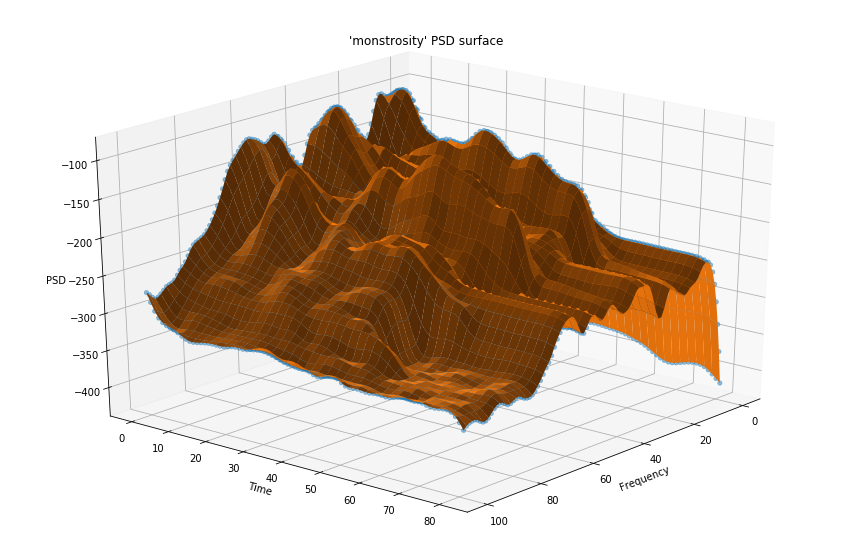

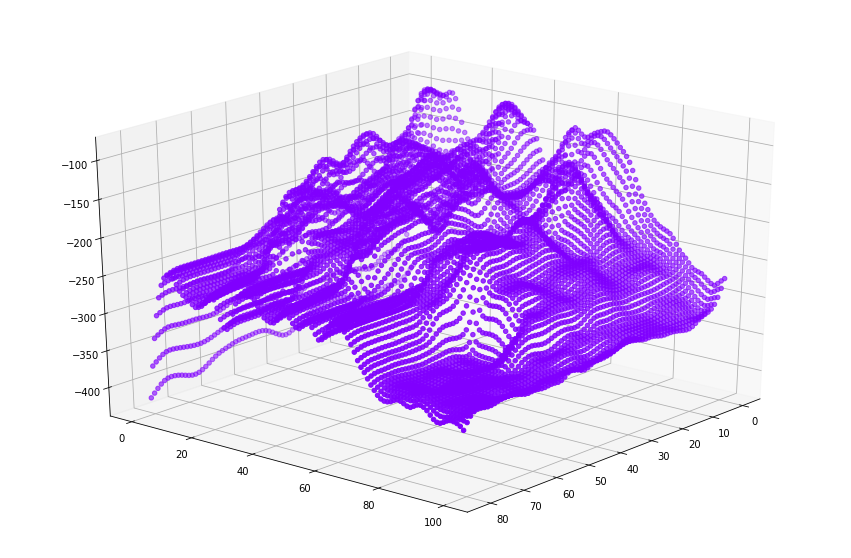

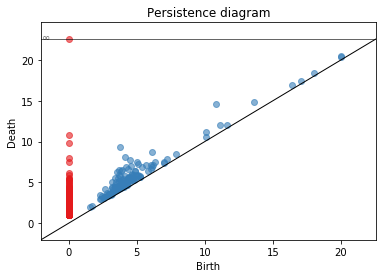

[(1, (3.7806349894049105, 9.373170706632674)),
 (1, (4.108481941975224, 8.128127752321152)),
 (1, (10.834621032492025, 14.560374853212597)),
 (1, (4.515803614999689, 7.713523336284365)),
 (1, (3.724800418367474, 6.5255914425917325)),
 (1, (4.174498821444644, 6.9385546092005015)),
 (1, (3.5570018842118625, 6.235139910381767)),
 (1, (3.9159317772969837, 6.556302311234732)),
 (1, (6.115864147454624, 8.701655927688952)),
 (1, (3.871169430701818, 6.350762584051409)),
 (1, (4.565958180858627, 7.019835095396818)),
 (1, (5.025348130603191, 7.4359144428043455)),
 (1, (4.339660395126689, 6.673971718875412)),
 (1, (3.6789018451574895, 5.957645107583893)),
 (1, (3.387084904312536, 5.584867023530532)),
 (1, (5.055553514704244, 7.202035706394693)),
 (1, (3.7313651773065386, 5.7543397536908145)),
 (1, (3.6316421888054204, 5.486938858416646)),
 (1, (3.19823469794754, 5.045190007235658)),
 (1, (4.142766000155998, 5.820479993574671)),
 (1, (4.837530657986933, 6.4482284567399075)),
 (1, (3.44142252243626

In [11]:
zdata_s = word_to_surface("monstrosity", myPath) #potato
    plot_and_pers_diagram(zdata_s, -160, True, True) #monstrosity

## Generalize to .wav Files

In [6]:
myPath = '/Users/luketrujillo/Desktop/Senior_year/Spring/Seminar_in_Diff_Geo/143_final_project/code/' #Path containing this notebook; change this

def wav_to_surface(wavFileName, myPath, accent='us'): #given a word, download the .mp3 from oxford and return the signal and frequency.
    myPath = '/Users/luketrujillo/Desktop/Senior_year/Spring/Seminar_in_Diff_Geo/143_final_project/code/'
    
    ## Setting paths for later; keeps things organized.
    wavPath = myPath + "wavs/"                      #full path for the the .wav files
    psdPath = myPath + "psd_data/"                  #full path for the psd data 
    matlabScriptsPath = myPath + "matlab_scripts/"  #full path to get to the matlab scripts

    print(wavFileName)
    
    psdCSV = psdPath + wavFileName + "_smooth_psd.csv" #our psd data
    if not os.path.isfile(psdCSV):              #if we haven't made the .csv before, then make it
        print("meow");
        wordWavPath = wavPath + wavFileName + ".wav"
        psd_smoother(wavFileName, wordWavPath, psdPath, matlabScriptsPath) #call helper function to compute psd
    
    word_psd = genfromtxt(psdCSV, delimiter=',')
    
    print(word_psd.shape)
    ## finally, we plot the surface
    xdata = [np.linspace(0, 81, 81), np.linspace(0, 100, 100)] #our x-y coordinates
    i,j = np.meshgrid(*xdata, indexing = "ij")              #creates the 81x100 grid
#     zdata_s = word_psd
    zdata_s = csaps(xdata, word_psd, xdata, smooth=0.3)   #using csaps to smooth our surface
    
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_facecolor('none')
    c = [s['color'] for s in plt.rcParams['axes.prop_cycle']]
    ax.scatter(j, i, zdata_s, linewidths=0.5, color=c[0], alpha=0.5)
    ax.plot_surface(j, i, zdata_s, color=c[1], linewidth=0, alpha=1)
    ax.view_init(elev=25, azim=40)
    
    plt.title("\'" + wavFileName + "\'" + " PSD surface")
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Time ')
    ax.set_zlabel('PSD')

    plt.show()
    
    return zdata_s

## We need to convert the phonemes from .m4a to .wav

In [39]:
from pydub import AudioSegment
phoneme_path = "/Users/luketrujillo/Desktop/Senior_year/Spring/Seminar_in_Diff_Geo/143_final_project/code/m4a_audios"

def m4a_to_wave(filename): #filename requires the m4a extension    
    try:
        filepath = phoneme_path + '/' + filename
        (path, file_extension) = os.path.splitext(filepath)
        file_extension_final = file_extension.replace('.', '')
        file_extension_final

        track = AudioSegment.from_file(filepath,file_extension_final)
        wav_filename = filename.replace(file_extension_final, 'wav')
        wav_path = myPath + 'wavs/' + wav_filename
        file_handle = track.export(wav_path, format='wav')
        os.remove(filepath)
        print("successfully converted")
    except:
        print("error converting" + filename)

for file in os.listdir(phoneme_path):
    if file.endswith(".m4a"):
        m4a_to_wave(file)

k
(81, 100)


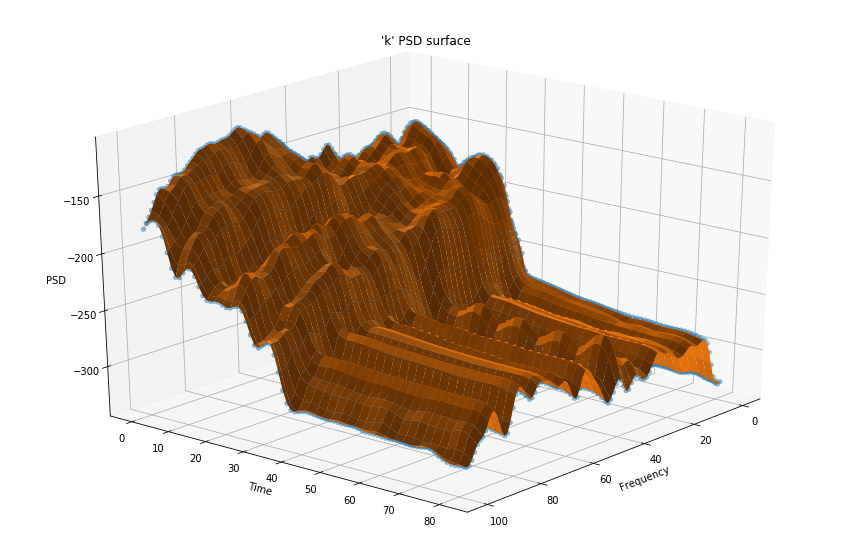

array([[-234.93312454, -233.56932677, -230.97678626, ..., -170.41642117,
        -174.81701203, -179.3999083 ],
       [-239.36930159, -236.31268762, -231.88232628, ..., -170.13718782,
        -172.09236298, -173.73269409],
       [-243.83935854, -238.86444411, -232.4048826 , ..., -170.89674189,
        -170.74952231, -169.86239691],
       ...,
       [-328.65849011, -327.2029663 , -324.35292002, ..., -315.5691081 ,
        -317.97936289, -318.21901681],
       [-328.31915874, -328.18161974, -326.00633975, ..., -316.96328969,
        -318.49350479, -317.78696159],
       [-328.14377936, -329.43152309, -327.91929184, ..., -318.64031751,
        -319.08723931, -317.1956331 ]])

In [7]:
wav_to_surface("k", myPath)